#            Project P63: Forecast Exchange Rates
## Business Objective:
 

Data provided is related to USD/INR Exchange rates. The objective is to understand the underlying structure in your dataset and come up with a suitable forecasting model which can effectively forecast USD/INR exchange rate for next 30 days. 
	This forecast model will be used by exporting and importing companies to understand the currency movements and accordingly set their revenue expectations.
	


In [339]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pandas import DataFrame
from pandas import Grouper
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,6
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pmd

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU
import tensorflow.keras.backend as K

from sklearn.preprocessing import MinMaxScaler


from sklearn.metrics import r2_score
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

# Data Collection

In [340]:
df = pd.read_csv(r'C:\Users\tejuh\Downloads\DEXINUS dataset.csv',header=0, index_col=0, parse_dates=True)


In [341]:
df

,Rates
dates,
1973-02-01,8.02
1973-03-01,8.02
1973-04-01,8.00
1973-05-01,8.01
1973-08-01,8.00
...,...
2021-06-21,74.18
2021-06-22,74.37
2021-06-23,74.13


In [342]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12649 entries, 1973-02-01 to 2021-06-25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rates   12155 non-null  float64
dtypes: float64(1)
memory usage: 197.6 KB


## Unique and missing values

In [343]:
uniqueValues = df.nunique()
print('Count of unique values in each column :')
print(uniqueValues)

Count of unique values in each column :
Rates    3526
dtype: int64


In [344]:
missingValues = df.isnull().sum()
print('Count of missing values in each column :')
print(missingValues)

Count of missing values in each column :
Rates    494
dtype: int64


## Correlation using Heatmap

<AxesSubplot:ylabel='dates'>

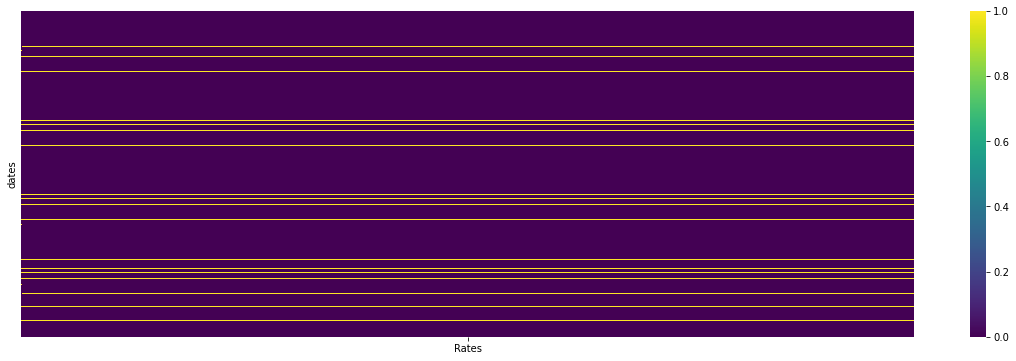

In [345]:
sns.heatmap(df.isnull(),yticklabels=False,cmap='viridis')

# Exploratory Data Analysis(EDA)

## Handling Missing Value's 
* By interpolate function

In [346]:
df1 = df.interpolate(method= 'linear')


In [347]:
df1

,Rates
dates,
1973-02-01,8.02
1973-03-01,8.02
1973-04-01,8.00
1973-05-01,8.01
1973-08-01,8.00
...,...
2021-06-21,74.18
2021-06-22,74.37
2021-06-23,74.13


In [311]:
missingValues = df1.isnull().sum()
print('Count of missing values in each column :')
print(missingValues)

Count of missing values in each column :
Rates    0
dtype: int64


In [312]:
df1.describe()

,Rates
count,12649.000000
mean,34.208211
std,21.114516
min,7.190000
25%,12.070000
50%,35.890000
75%,47.670000
max,76.950000


## Updated Correlation

<AxesSubplot:ylabel='dates'>

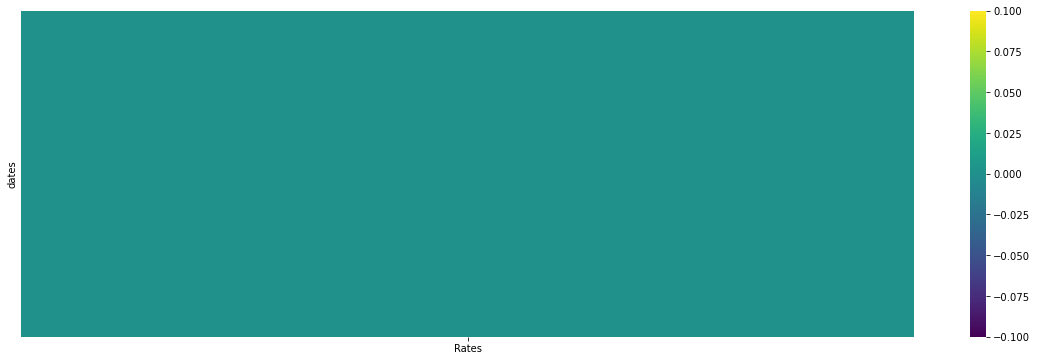

In [313]:
sns.heatmap(df1.isnull(),yticklabels=False,cmap='viridis')

# Visualizations
* Using Whole dataset

<AxesSubplot:xlabel='dates'>

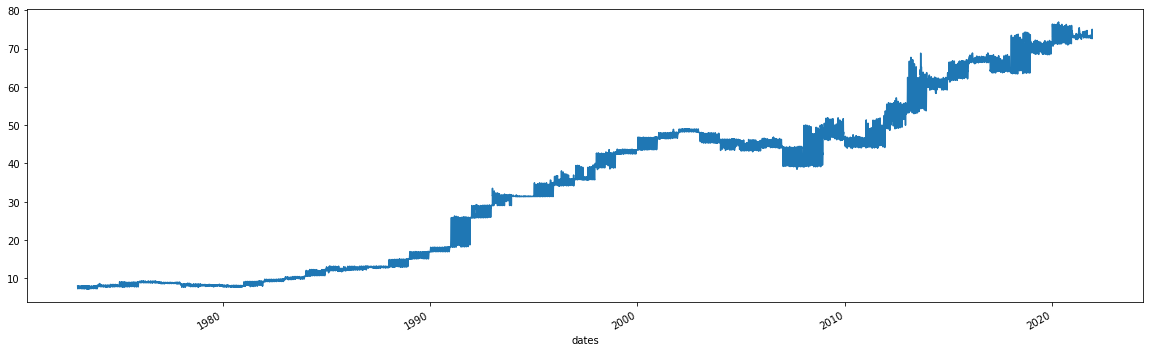

In [314]:
df1.Rates.plot()

### Method of Valuation for currency
* There are two methods
* Fixed: Up to 1993 Government will decide the price
* Flexible: after 1993 Market will decide the price (market demand high-value up and market demand low supply high-value down)

<AxesSubplot:ylabel='Density'>

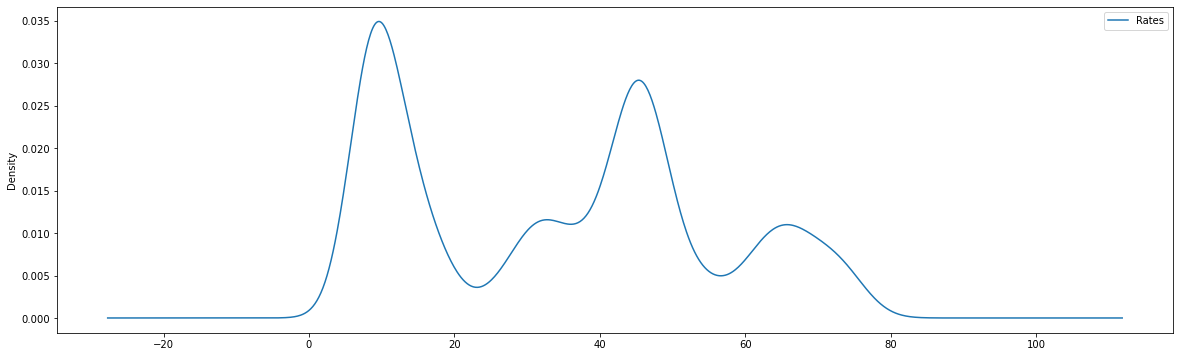

In [315]:
df1.plot(kind='kde')

(array([4821., 1228., 3968.,  974., 1658.]),
 array([ 7.19 , 21.142, 35.094, 49.046, 62.998, 76.95 ]),
 <BarContainer object of 5 artists>)

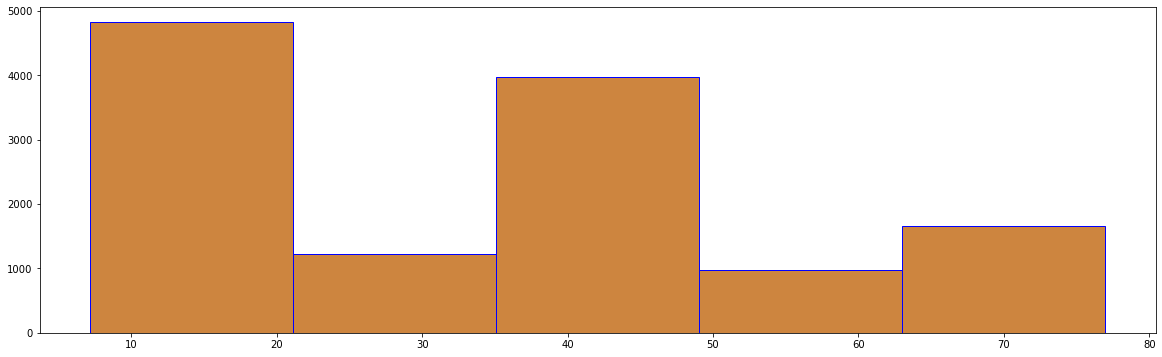

In [316]:
plt.hist(df1['Rates'],facecolor ="peru",edgecolor ="blue",bins =5)
#creates histogram with 5bins and colours filled init.

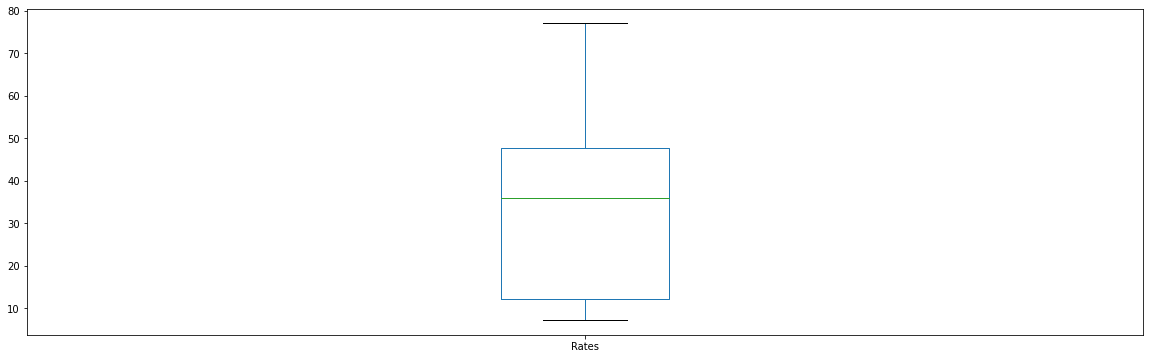

In [317]:
# Box and Whisker Plots
df1.plot(kind='box', subplots=True, layout=(1,1), sharex=False, sharey=False)
plt.show()

# Data Pre-Processing
## Statistical Testing 
* Rolling Statistics

In [318]:
#Determing rolling statistics
rolmean = df1.rolling(window=4).mean()
rolstd = df1.rolling(window=4).std()
print(rolmean, rolstd)

              Rates
dates              
1973-02-01      NaN
1973-03-01      NaN
1973-04-01      NaN
1973-05-01   8.0125
1973-08-01   8.0075
...             ...
2021-06-21  73.9475
2021-06-22  74.2125
2021-06-23  74.2050
2021-06-24  74.2050
2021-06-25  74.1950

[12649 rows x 1 columns]                Rates
dates               
1973-02-01       NaN
1973-03-01       NaN
1973-04-01       NaN
1973-05-01  0.009574
1973-08-01  0.009574
...              ...
2021-06-21  0.425314
2021-06-22  0.106262
2021-06-23  0.112101
2021-06-24  0.112101
2021-06-25  0.116762

[12649 rows x 1 columns]


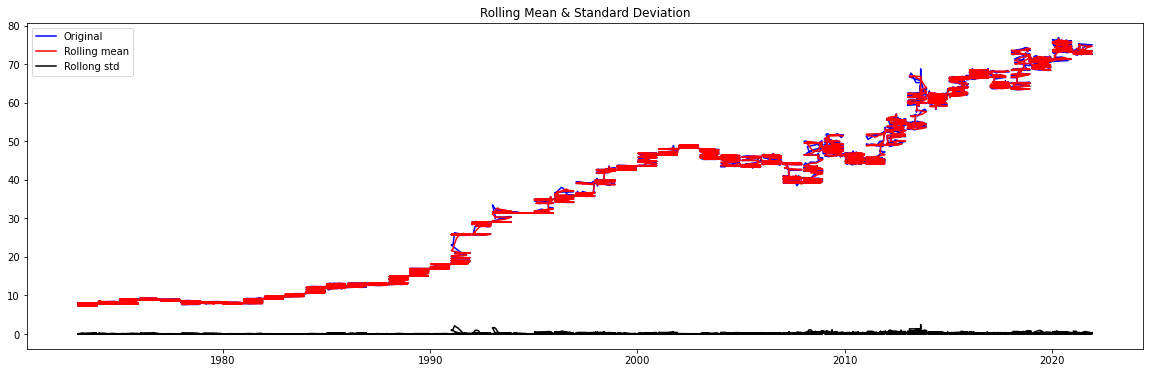

In [319]:
# Plot rolling statistics
orig = plt.plot(df1, color='blue',label='Original')
mean = plt.plot(rolmean,color='red',label='Rolling mean')
std = plt.plot(rolstd, color='black',label='Rollong std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=True)

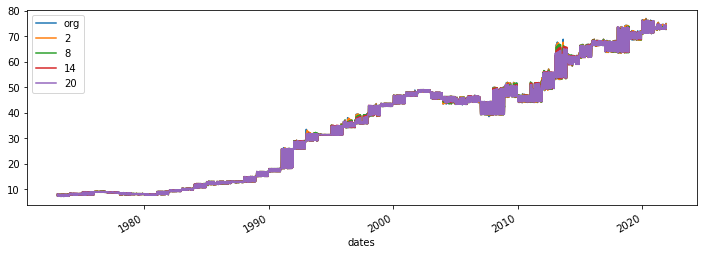

In [320]:
plt.figure(figsize=(12,4))
df1.Rates.plot(label="org")
for i in range(2,24,6):
    df1["Rates"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

## Make Dataset Stationary

In [321]:
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF :",dftest[0])
    print("2. P-value :",dftest[1])
    print("3. Num of lags :",dftest[2])
    print("4. Num of observations used for ADF regression and critical values calculation :", dftest[3])
    print("5. critical values :")
    for key, val in dftest[4].items():
        print('\t',key,":",val)


In [322]:
ad_test(df1['Rates'])

1. ADF : 0.6034527121860712
2. P-value : 0.9877004241159653
3. Num of lags : 40
4. Num of observations used for ADF regression and critical values calculation : 12608
5. critical values :
	 1% : -3.430868768391228
	 5% : -2.8617692699928945
	 10% : -2.5668920354374247


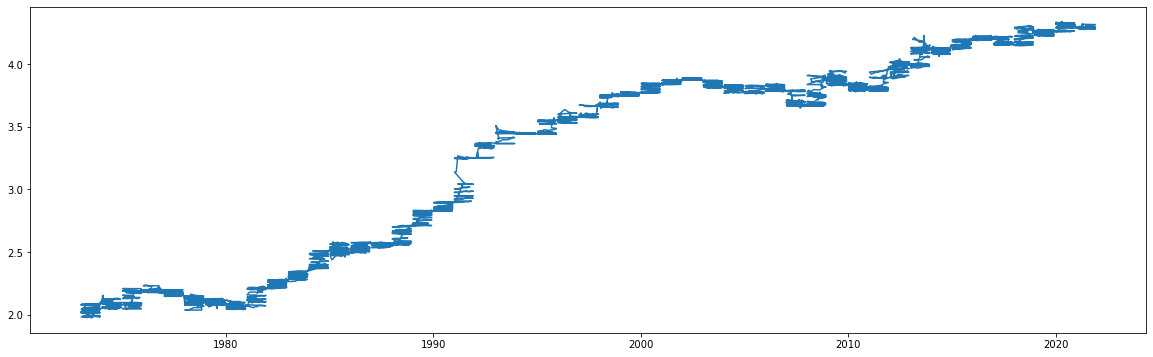

In [323]:
# Estimating trend
df1_logScale = np.log(df1)
plt.plot(df1_logScale)

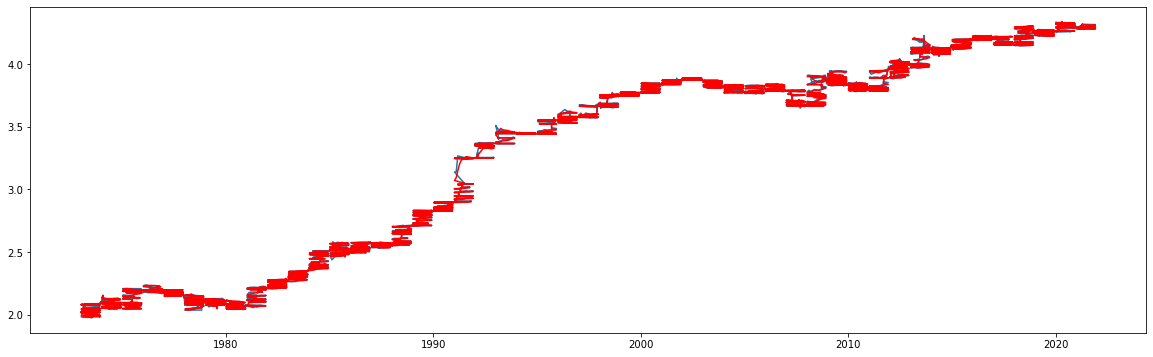

In [324]:
movingAverage = df1_logScale.rolling(window=4).mean()
movingSTD = df1_logScale.rolling(window=4).std()
plt.plot(df1_logScale)
plt.plot(movingAverage, color='red')


In [325]:
datasetLogScaleMinusMovingAverage = df1_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NaN Values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,Rates
dates,
1973-05-01,-3.115255e-04
1973-08-01,-9.365249e-04
1973-09-01,-3.123049e-04
1973-10-01,-3.123049e-04
1973-11-01,-4.440892e-16
1973-12-01,-4.440892e-16
1973-01-15,-4.440892e-16
1973-01-16,9.369146e-04
1973-01-17,6.246097e-04


In [326]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    # Determing rolling statistics
    movingAverage = timeseries.rolling(window=4).mean()
    movingSTD = timeseries.rolling(window=4).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(movingAverage,color='red',label='Rolling mean')
    std = plt.plot(movingSTD, color='black',label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling mean & Rolling Stadard Deviation')
    plt.show(block=False)
    
    #Perform Test
    
    dftest = adfuller(timeseries['Rates'], autolag = 'AIC')
    print("1. ADF :",dftest[0])
    print("2. P-value :",dftest[1])
    print("3. Num of lags :",dftest[2])
    print("4. Num of observations used for ADF regression and critical values calculation :", dftest[3])
    print("5. critical values :")
    for key, val in dftest[4].items():
        print('\t',key,":",val)

    

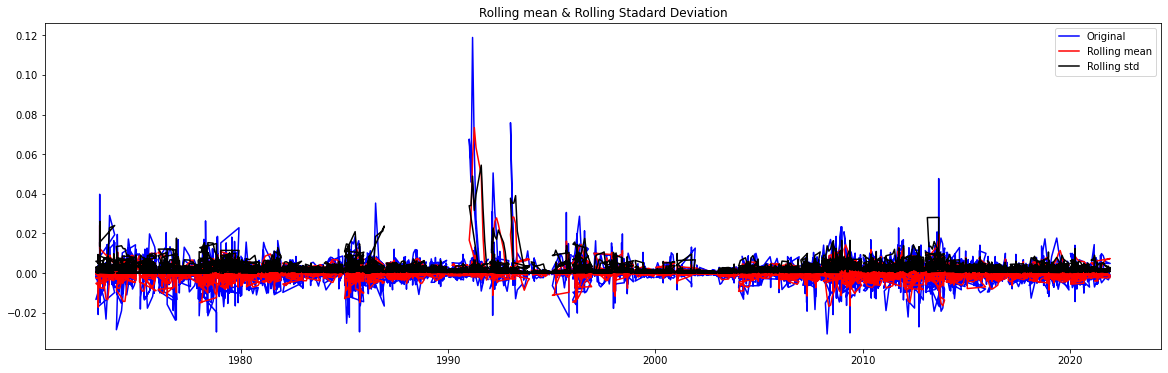

1. ADF : -36.515523364234795
2. P-value : 0.0
3. Num of lags : 7
4. Num of observations used for ADF regression and critical values calculation : 12638
5. critical values :
	 1% : -3.4308675366920256
	 5% : -2.8617687256901454
	 10% : -2.566891745708671


In [327]:
test_stationarity(datasetLogScaleMinusMovingAverage)

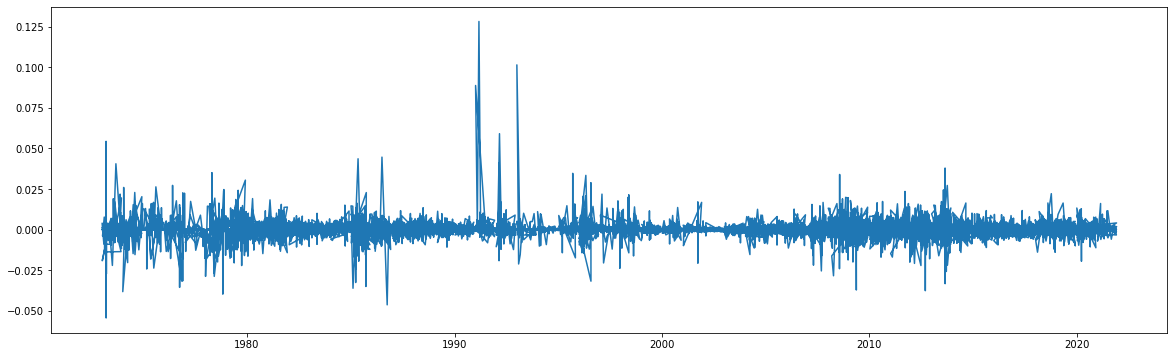

In [328]:
datasetLogDiffShifting = df1_logScale - df1_logScale.shift()
plt.plot(datasetLogDiffShifting)

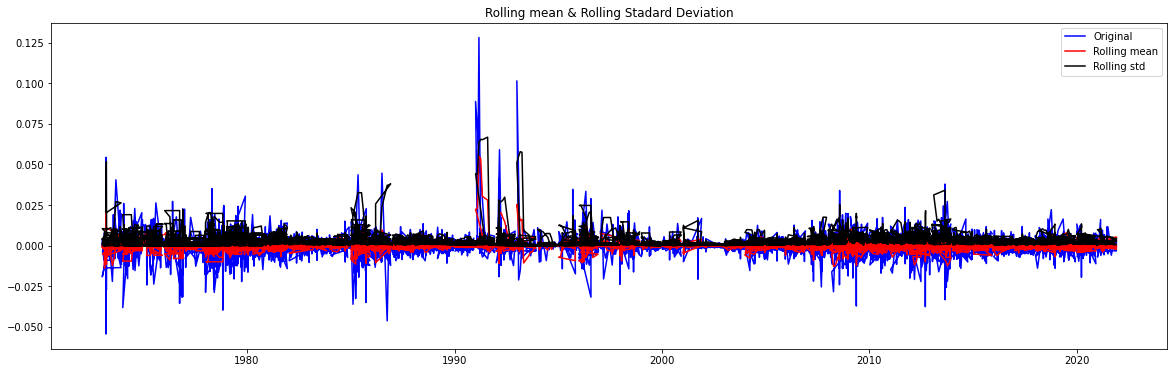

1. ADF : -37.30285981923266
2. P-value : 0.0
3. Num of lags : 8
4. Num of observations used for ADF regression and critical values calculation : 12639
5. critical values :
	 1% : -3.4308674957361065
	 5% : -2.8617687075912266
	 10% : -2.5668917360747368


In [329]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

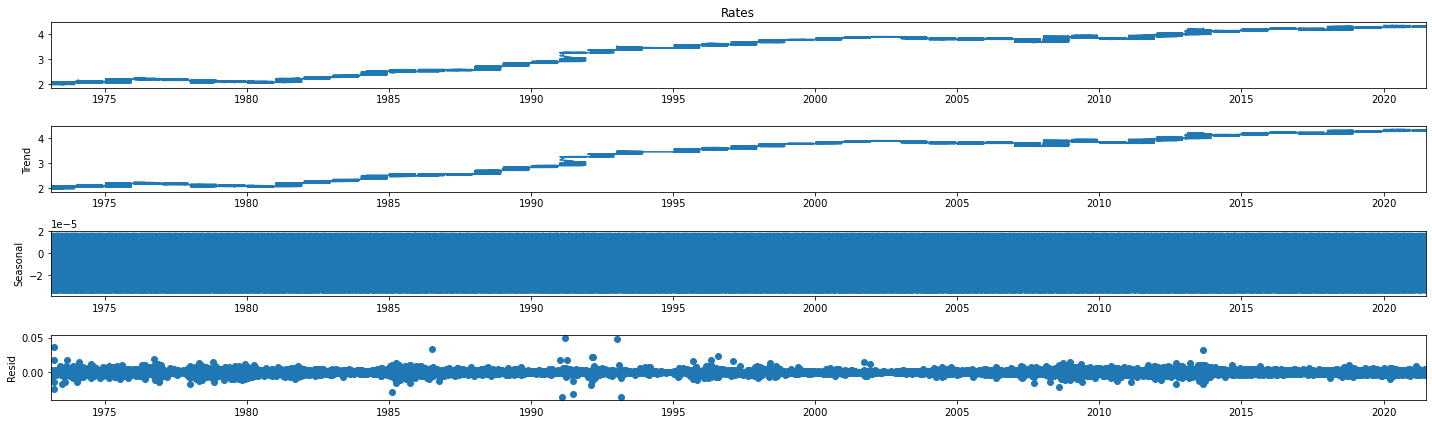

In [330]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_ts_add = seasonal_decompose(df1_logScale.Rates,period=4)
decompose_ts_add.plot()
plt.show()


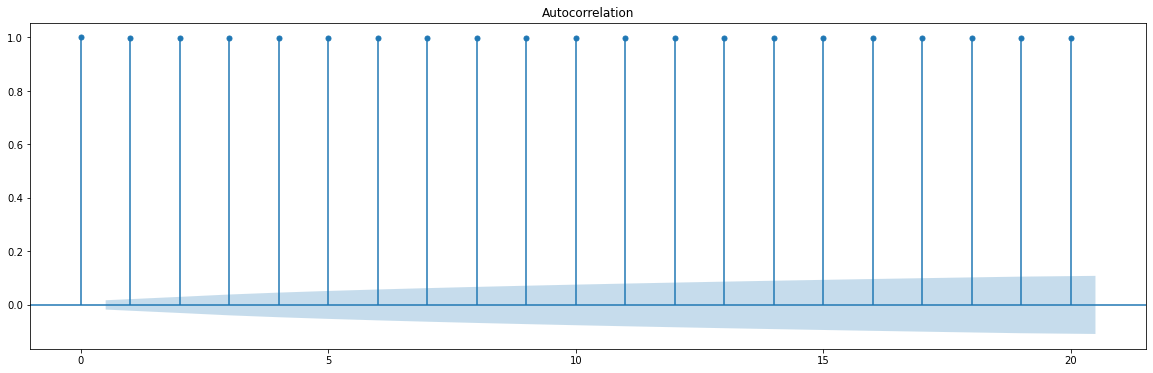

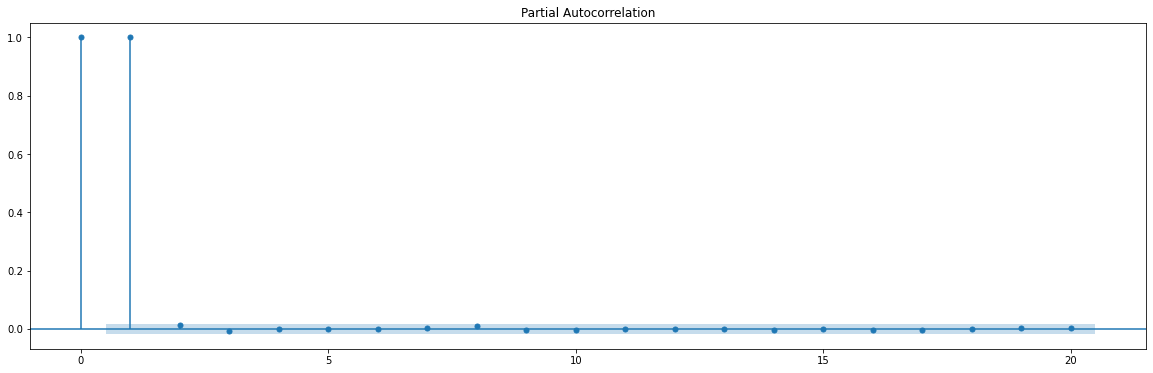

In [332]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(df1_logScale.Rates,lags=1)
tsa_plots.plot_pacf(df1_logScale.Rates,lags=12)
plt.show()


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

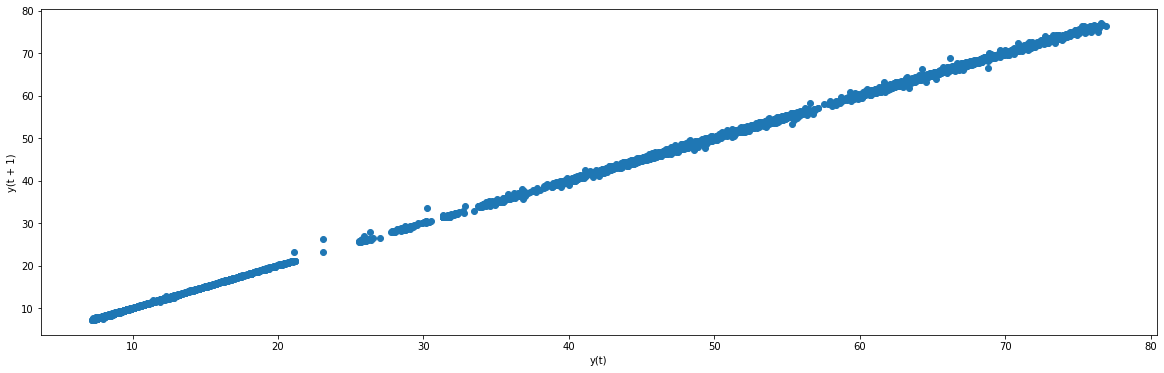

In [333]:
from pandas.plotting import lag_plot
lag_plot(df1)

# Model Building From Different Forecasting Methods and Evaluation

## Holt's Method
* Also called as Double Exponential Smoothing Technique.
* Updated technique from SEST.
* This method is suitable for univariate time series with trend components.

In [275]:
df1.head() # balanced dataset

,Rates
dates,
1973-02-01,8.02
1973-03-01,8.02
1973-04-01,8.00
1973-05-01,8.01
1973-08-01,8.00


In [279]:
from pandas import datetime
from datetime import timedelta
train = datetime(2016,6,30)
test = datetime(2021,6,25)

X = df1[:train]
Y = df1[train + timedelta(days=1):test]

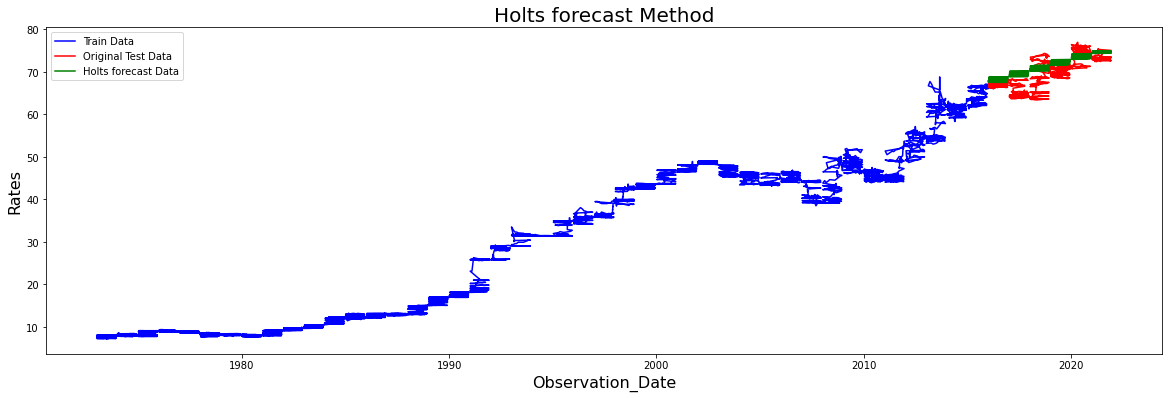

In [280]:
from statsmodels.tsa.api import ExponentialSmoothing

import warnings
warnings.filterwarnings("ignore")

holt = ExponentialSmoothing(np.asarray(X['Rates']),
                            trend='add',
                            damped_trend=False,
                            seasonal=None,
                            seasonal_periods='30 days')
fit = holt.fit()
forecast = fit.forecast(len(Y))

plt.plot(X.index, X['Rates'], 'blue', label='Train Data')
plt.plot(Y.index, Y['Rates'], 'red', label='Original Test Data')
plt.plot(Y.index, forecast, 'green', label='Holts forecast Data')
plt.ylabel("Rates", fontsize=16)
plt.xlabel("Observation_Date", fontsize=16)
plt.legend(loc='best')
plt.title('Holts forecast Method', fontsize=20)
plt.show()

In [281]:
holt.params

{'smoothing_level': 0.9713880886609757,
 'smoothing_trend': 3.0023673003241763e-18,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 8.014928906041941,
 'initial_trend': 0.005240044004637096,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [282]:
np.array(Y)

array([[66.73],
       [66.82],
       [66.78],
       ...,
       [74.13],
       [74.14],
       [74.14]])

In [283]:
forecast

array([67.51318085, 67.51842089, 67.52366093, ..., 74.97500351,
       74.98024355, 74.9854836 ])

In [284]:
Expected = Y
Predictions = forecast
Predictions = Predictions.reshape(1427, 1)

Forecast_error = Expected - Predictions
np.array(Forecast_error)

array([[-0.78318085],
       [-0.69842089],
       [-0.74366093],
       ...,
       [-0.84500351],
       [-0.84024355],
       [-0.8454836 ]])

In [273]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(Y, Predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.892


## AR Model
* A regression model, such as linear regression, models an output value based on a linear combination of input values.
* This technique can be used on time series where input variables are taken as observations at previous time steps, called lag variables.

In [256]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

In [257]:
df1.head()

,Rates
dates,
1973-02-01,8.02
1973-03-01,8.02
1973-04-01,8.00
1973-05-01,8.01
1973-08-01,8.00


In [258]:
X1 = np.array(df1.values)
train, test = X1[1:len(X)-30], X1[len(X)-30:]   # 100 step

Coefficients: [0.00277125 1.00008291]
predicted=67.578374, expected=67.420000
predicted=67.586748, expected=67.470000
predicted=67.595123, expected=67.590000
predicted=67.603499, expected=67.280000
predicted=67.611875, expected=66.900000
predicted=67.620253, expected=66.960000
predicted=67.628630, expected=67.040000
predicted=67.637009, expected=67.120000
predicted=67.645388, expected=67.440000
predicted=67.653768, expected=67.220000
predicted=67.662149, expected=66.990000
predicted=67.670530, expected=66.810000
predicted=67.678912, expected=66.640000
predicted=67.687295, expected=66.510000
predicted=67.695678, expected=66.680000
predicted=67.704063, expected=66.840000
predicted=67.712447, expected=67.170000
predicted=67.720833, expected=67.340000
predicted=67.729219, expected=67.080000
predicted=67.737606, expected=67.430000
predicted=67.745994, expected=67.110000
predicted=67.754382, expected=67.540000
predicted=67.762771, expected=67.730000
predicted=67.771161, expected=67.490000
pr

predicted=73.862419, expected=70.020000
predicted=73.871315, expected=70.090000
predicted=73.880211, expected=70.000000
predicted=73.889108, expected=69.820000
predicted=73.898006, expected=69.620000
predicted=73.906904, expected=69.520000
predicted=73.915803, expected=69.330000
predicted=73.924703, expected=68.940000
predicted=73.933603, expected=68.600000
predicted=73.942505, expected=69.020000
predicted=73.951407, expected=68.850000
predicted=73.960310, expected=68.720000
predicted=73.969213, expected=69.010000
predicted=73.978117, expected=68.880000
predicted=73.987022, expected=68.980000
predicted=73.995928, expected=69.130000
predicted=74.004835, expected=69.230000
predicted=74.013742, expected=69.160000
predicted=74.022650, expected=69.180000
predicted=74.031559, expected=68.910000
predicted=74.040468, expected=68.580000
predicted=74.049378, expected=69.030000
predicted=74.058289, expected=69.110000
predicted=74.067201, expected=69.560000
predicted=74.076113, expected=69.280000


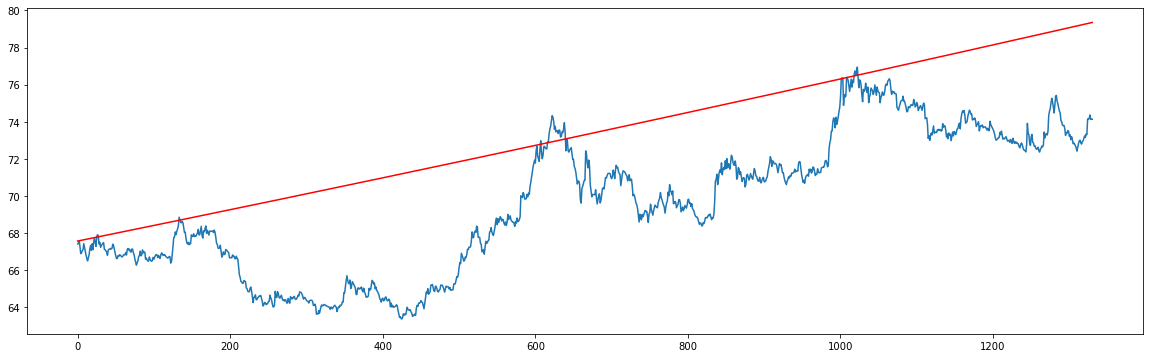

In [261]:
# train autoregression
model = AutoReg(train, lags=1)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## ARIMA Model
* ‘Auto Regressive Integrated Moving Average’


In [351]:
def ARIMA_Model(df1,p,d,q):
    
    val = df1.values
    val = val.astype('float32')
    train, test = val[1:len(val)-30], val[len(val)-30:]
    history = [x for x in train]
    predictions = list()
    
    for i in range(len(test)):
        arima_model = ARIMA(history, order=(p,d,q)).fit()
        output = arima_model.forecast()
        ypred = output[0]
        predictions.append(ypred)
        act = test[i]
        history.append(act)
        print('predicted=%f, expected=%f' % (ypred, act))
       
    # evaluate forecasts
    residuals = test - predictions 
    rmse = np.sqrt(np.mean(residuals**2))
    print('Root Mean Squared Error: %.3f' %rmse)
    mape = np.mean(abs(residuals/test))
    print('Mean Absolute Percentage Error: %.3f' %mape)
    
    #Print summary of the model
    print(arima_model.summary())
    
    # plot forecasts against actual outcomes
    forecast=arima_model.forecast(steps=30,alpha=0.05)[0]
    arima_model.plot_predict()
    arima_model.plot_predict(12619,12649)

predicted=73.242710, expected=73.300003
predicted=73.316392, expected=73.040001
predicted=73.047061, expected=73.199997
predicted=73.215072, expected=73.029999
predicted=73.031022, expected=72.820000
predicted=72.837756, expected=72.860001
predicted=72.874912, expected=72.779999
predicted=72.785071, expected=72.709999
predicted=72.720691, expected=72.589996
predicted=72.601146, expected=72.419998
predicted=72.434498, expected=72.625000
predicted=72.634776, expected=72.830002
predicted=72.821612, expected=72.970001
predicted=72.962890, expected=73.010002
predicted=73.007949, expected=72.870003
predicted=72.876200, expected=72.800003
predicted=72.813598, expected=72.930000
predicted=72.936418, expected=72.980003
predicted=72.978228, expected=73.099998
predicted=73.100795, expected=73.239998
predicted=73.237037, expected=73.160004
predicted=73.160223, expected=73.349998
predicted=73.355789, expected=73.309998
predicted=73.307062, expected=74.160004
predicted=74.151280, expected=74.139999


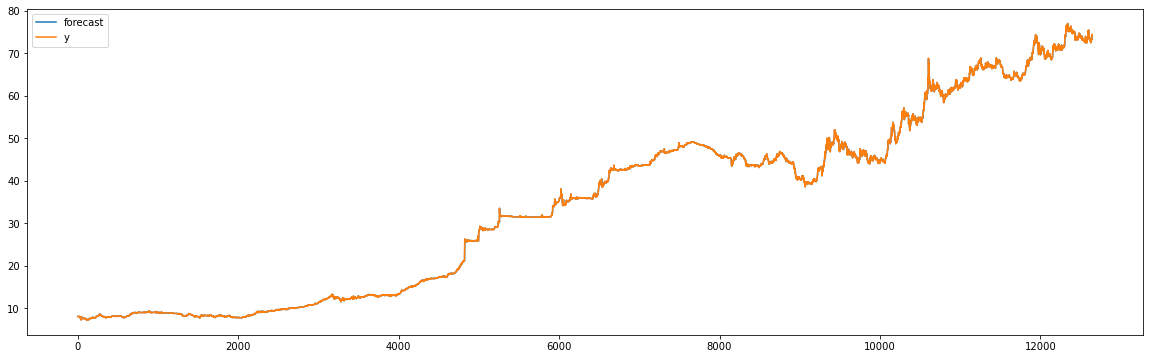

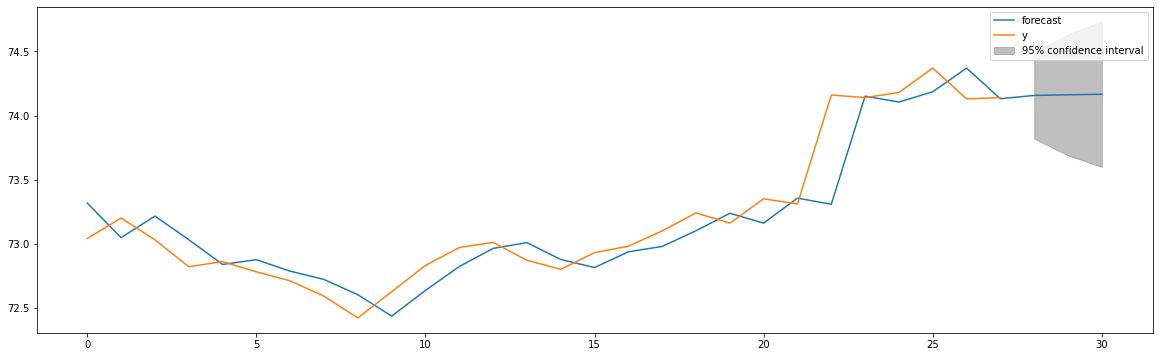

In [361]:
# For non-seasonal data
#p=1, d=1, q=0 or 1
ARIMA_Model(df1,2,1,0)

## Using Fb-prophet Model
* Prophet: Automatic Forecasting Procedure
* Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. 

In [244]:
#!conda install -c conda-forge fbprophet -y
#!pip install --upgrade plotly
import fbprophet
df1.reset_index(level=0, inplace=True)

In [245]:
df1.head()

,dates,Rates
0,1973-02-01,8.02
1,1973-03-01,8.02
2,1973-04-01,8.00
3,1973-05-01,8.01
4,1973-08-01,8.00


In [247]:
df2 = df1.columns = ['ds','y']

In [ ]:
from fbprophet import Prophet

In [138]:
dir(Prophet)  # Prophet function

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_load_stan_backend',
 'add_country_holidays',
 'add_group_component',
 'add_regressor',
 'add_seasonality',
 'construct_holiday_dataframe',
 'fit',
 'flat_growth_init',
 'flat_trend',
 'fourier_series',
 'initialize_scales',
 'linear_growth_init',
 'logistic_growth_init',
 'make_all_seasonality_features',
 'make_future_dataframe',
 'make_holiday_features',
 'make_seasonality_features',
 'parse_seasonality_args',
 'percentile',
 'piecewise_linear',
 'piecewise_logistic',
 'plot',
 'plot_components',
 'predict',
 'predict_seasonal_components',
 'predict_trend',
 'predict_uncertainty',
 'predictive_samples',
 'regressor_col

In [139]:
model = Prophet()

In [140]:
df1.columns

Index(['ds', 'y'], dtype='object')

In [141]:
model.fit(df1)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [142]:
model.component_modes

{'additive': ['yearly',
  'weekly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [143]:
df1.tail()

,ds,y
12644,2021-06-21,74.18
12645,2021-06-22,74.37
12646,2021-06-23,74.13
12647,2021-06-24,74.14
12648,2021-06-25,74.14


In [185]:
# create future date's for next 30 days
future_dates = model.make_future_dataframe(periods=30)

In [186]:
future_dates.tail()

,ds
12674,2021-12-31
12675,2022-01-01
12676,2022-01-02
12677,2022-01-03
12678,2022-01-04


In [187]:
predictions = model.predict(future_dates)

In [188]:
predictions.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1973-01-02,7.411367,5.522361,10.091039,7.411367,7.411367,0.425401,0.425401,0.425401,0.001972,0.001972,0.001972,0.423429,0.423429,0.423429,0.0,0.0,0.0,7.836769
1,1973-01-03,7.412590,5.583912,9.947939,7.412590,7.412590,0.457106,0.457106,0.457106,0.031098,0.031098,0.031098,0.426008,0.426008,0.426008,0.0,0.0,0.0,7.869697
2,1973-01-05,7.415035,5.575305,10.042369,7.415035,7.415035,0.413570,0.413570,0.413570,-0.001018,-0.001018,-0.001018,0.414588,0.414588,0.414588,0.0,0.0,0.0,7.828606
3,1973-01-06,7.416258,5.224509,9.973911,7.416258,7.416258,0.315832,0.315832,0.315832,-0.085452,-0.085452,-0.085452,0.401284,0.401284,0.401284,0.0,0.0,0.0,7.732090
4,1973-01-08,7.418703,5.498158,10.198842,7.418703,7.418703,0.344158,0.344158,0.344158,-0.017809,-0.017809,-0.017809,0.361967,0.361967,0.361967,0.0,0.0,0.0,7.762861


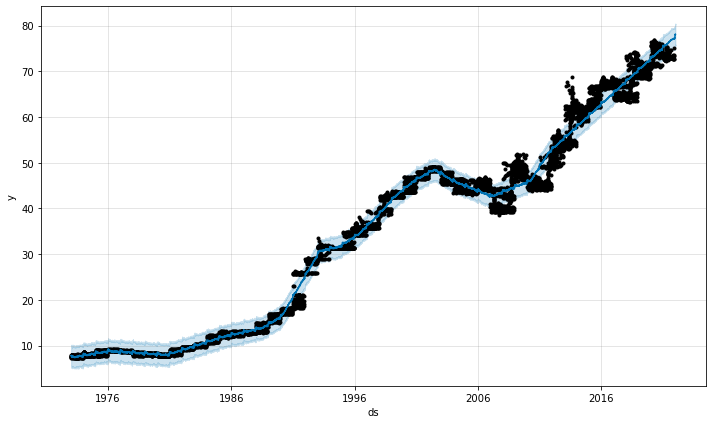

In [189]:
# plot the predicted projections
model.plot(predictions)
plt.show()

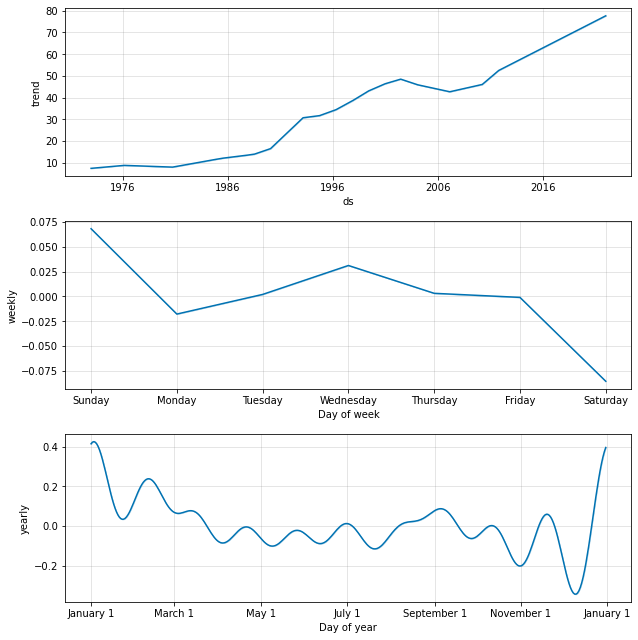

In [190]:
# visualize the component plot with trend,weekly,yearly
model.plot_components(predictions)
plt.show()

In [194]:
from fbprophet.diagnostics import cross_validation
df1_cv = cross_validation(model,
                          initial='3650 days',
                          period='365 days',
                          horizon='30 days')
df1_cv.head()

INFO:fbprophet:Making 39 forecasts with cutoffs between 1983-11-15 00:00:00 and 2021-11-05 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1983-11-16,10.329308,10.042845,10.612484,10.38,1983-11-15
1,1983-11-17,10.333590,10.056922,10.603724,10.40,1983-11-15
2,1983-11-18,10.332488,10.048886,10.584641,10.41,1983-11-15
3,1983-11-21,10.355319,10.090895,10.625540,10.45,1983-11-15
4,1983-11-22,10.348190,10.071815,10.626751,10.41,1983-11-15


In [195]:
 from fbprophet.diagnostics import performance_metrics
df1_p = performance_metrics(df1_cv)    # take y and yhat values, compare it and find out errors
df1_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,8.130390,2.851384,2.028078,0.046790,0.041943,0.444444
1,4 days,8.927350,2.987867,2.073528,0.046693,0.040020,0.448854
2,5 days,8.778376,2.962832,2.070357,0.047421,0.040333,0.437797
3,6 days,9.477807,3.078605,2.143396,0.049064,0.042034,0.415181
4,7 days,9.219464,3.036357,2.093824,0.048547,0.043193,0.458689
5,8 days,8.783088,2.963628,2.014341,0.046456,0.043335,0.484036
6,9 days,8.142648,2.853532,1.960577,0.046431,0.043868,0.469136
7,10 days,7.918802,2.814037,1.941749,0.046281,0.043335,0.444444
8,11 days,8.374049,2.893795,1.988466,0.047037,0.043863,0.432099
9,12 days,8.789678,2.964739,2.010248,0.047529,0.043863,0.442158


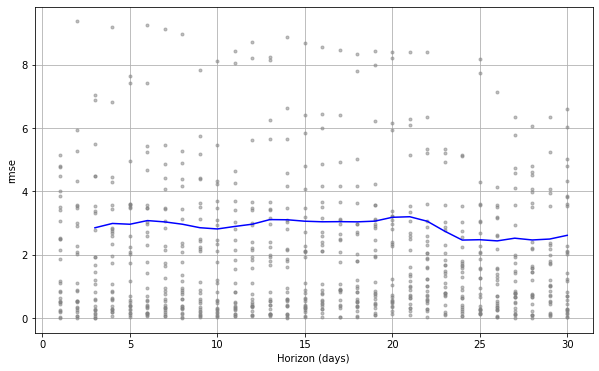

In [196]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df1_cv,metric='rmse')

## Using pycaret
* PyCaret is simple and easy to use machine learning library that will help you to perform end-to-end ML experiments with less lines of code.

In [197]:
data = pd.read_excel(r'C:\Users\tejuh\Downloads\DEXINUS D.xlsx')
data = data.interpolate(method= 'linear')
data

,dates,Rates
0,1973-01-02,8.02
1,1973-01-03,8.02
2,1973-01-04,8.00
3,1973-01-05,8.01
4,1973-01-08,8.00
...,...,...
12644,2021-06-21,74.18
12645,2021-06-22,74.37
12646,2021-06-23,74.13
12647,2021-06-24,74.14


In [198]:
# extract month and year from dates
data['year'] = pd.DatetimeIndex(data['dates']).year
data['month'] = pd.DatetimeIndex(data['dates']).month

In [199]:
# create a sequence of numbers
data['Series'] = np.arange(1,len(data)+1)# drop unnecessary columns and re-arrange
data = data[['Series','year', 'month', 'Rates']]# check the head of the dataset
data

,Series,year,month,Rates
0,1,1973,1,8.02
1,2,1973,1,8.02
2,3,1973,1,8.00
3,4,1973,1,8.01
4,5,1973,1,8.00
...,...,...,...,...
12644,12645,2021,6,74.18
12645,12646,2021,6,74.37
12646,12647,2021,6,74.13
12647,12648,2021,6,74.14


In [65]:
# split data into train-test set
train = data[data['year'] < 2019]
test = data[data['year'] >= 2019]# check shape
train.shape, test.shape

((12000, 4), (649, 4))

In [66]:
# import the regression module
from pycaret.regression import *  # initialize setup
s = setup(data=train, test_data=test, target='Rates', fold_strategy='timeseries',
          numeric_features=['year', 'Series'], fold=3, transform_target=True, session_id=123)

,Description,Value
0,session_id,123
1,Target,Rates
2,Original Data,"(12000, 4)"
3,Missing Values,False
4,Numeric Features,2
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(12000, 13)"


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=['year', 'Series'],
                                      target='Rates', time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                num...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluster_all', 'passthrough'),
             

In [67]:
best = compare_models(sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,10.3883,167.0684,12.5734,-2.3625,0.3877,0.2615,1.4633
dt,Decision Tree Regressor,10.5695,169.8767,12.7484,-2.5730,0.3937,0.2665,0.2533
et,Extra Trees Regressor,10.7968,174.0406,12.9581,-2.8178,0.3996,0.2717,0.3300
rf,Random Forest Regressor,10.8716,175.1820,13.0204,-2.9030,0.4015,0.2737,0.3433
knn,K Neighbors Regressor,11.3324,184.0263,13.4210,-3.4041,0.4148,0.2858,2.4933
lightgbm,Light Gradient Boosting Machine,11.3711,185.3135,13.4929,-3.5858,0.4144,0.2845,0.9533
gbr,Gradient Boosting Regressor,11.4658,187.5945,13.5850,-3.7231,0.4162,0.2859,0.2700
ada,AdaBoost Regressor,11.7987,192.3038,13.8487,-4.4546,0.4371,0.3028,0.2767
par,Passive Aggressive Regressor,20.0405,558.1101,21.8601,-25.2095,0.8585,0.5038,1.5233
llar,Lasso Least Angle Regression,26.9381,897.0404,28.2514,-26.4564,1.0498,0.6341,1.6300


INFO:logs:create_model_container: 11
INFO:logs:master_model_container: 11
INFO:logs:display_container: 2
INFO:logs:PowerTransformedTargetRegressor(base_score=None, booster='gbtree',
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None, gamma=None, gpu_id=None,
                                importance_type='gain',
                                interaction_constraints=None,
                                learning_rate=None, max_delta_step=None,
                                max_depth=None, min_child_weight=None,
                                missing=nan, monotone_constraints=None,
                                n_estimators=100, n_jobs=-1,
                                nu...
                                                       missing=nan,
                                                       monotone_constraints=None,
                                                       n_estimators=100,
   

In [68]:
prediction_holdout = predict_model(best);

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=PowerTransformedTargetRegressor(base_score=None, booster='gbtree',
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None, gamma=None, gpu_id=None,
                                importance_type='gain',
                                interaction_constraints=None,
                                learning_rate=None, max_delta_step=None,
                                max_depth=None, min_child_weight=None,
                                missing=nan, monotone_constraints=None,
                                n_estimators=100, n_jobs=-1,
                                nu...
                                                       missing=nan,
                                                       monotone_constraints=None,
                                                       n_estimators=100,
                                             

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,4.8493,34.0043,5.8313,-6.6989,0.0826,0.0663


## Artificial Neural Network(ANN)
* ANNs are biologically inspired computational networks. 
* used in supervised learning problems in which we know the target labels of the data.
* It consists of mainly three layers: input, hidden, and output layer.

In [97]:
def ANN_Model(df1):
    df1 = np.array(df1)
    scaler = MinMaxScaler()
    df_1 = scaler.fit_transform(df1)
    
    #Training and test sets
    train = df_1[:11919]
    test = df_1[11919:]
    
    X_train = train[:-1]
    y_train = train[1:]

    X_test = test[:-1]
    y_test = test[1:]
    
    #Create model
    K.clear_session()
    ann_model = Sequential()
    ann_model.add(Dense(12, input_dim=1, activation='relu'))
    ann_model.add(Dense(1))
    ann_model.summary()
    
    ann_model.compile(loss= 'mse', metrics=[tensorflow.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
    history = ann_model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)
    
    #Prediction
    y_pred = ann_model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test = scaler.inverse_transform(y_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)
    print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred)))
    r2_test = r2_score(y_test, y_pred)
    print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
    print("Root Mean Squared Error: %.3f" %rmse)
    
    return y_test,y_pred

In [99]:
y_test1,y_pred1 = ANN_Model(df1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                24        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
11918/11918 [==============================] - 17s 1ms/step - loss: 9.2666e-06 - rmse: 0.0030
Epoch 2/200
11918/11918 [==============================] - 17s 1ms/step - loss: 9.9439e-05 - rmse: 0.0100
Epoch 3/200
11918/11918 [==============================] - 16s 1ms/step - loss: 4.6026e-05 - rmse: 0.0068
Epoch 00003: early stopping
The R2 score on the Test set is:	0.900
The Adjusted R2 score on the Test set is:	0.900
Root Mean Squared Error: 0.641


In [100]:
def NeuralNet_Plot(y_test,y_pred):
    
    plt.figure(figsize=(12,8))
    plt.title('USD-INR Prediction')
    plt.plot(y_test , label = 'Actual')
    plt.plot(y_pred , label = 'Predicted')
    plt.xlabel('Observation')
    plt.ylabel('Rates')
    plt.legend()

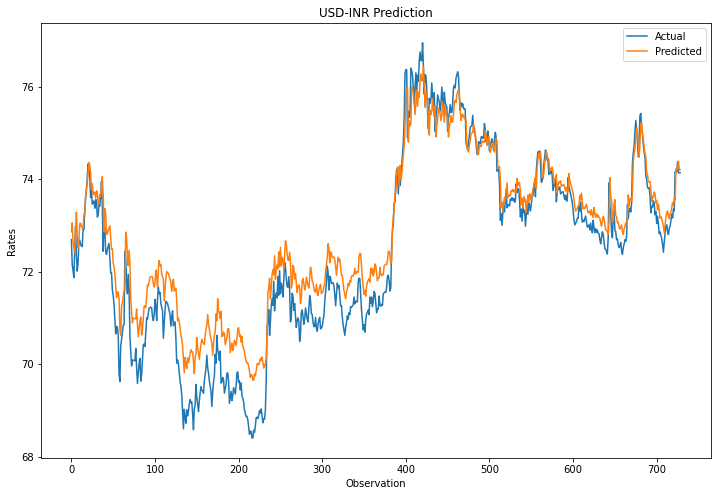

In [101]:
NeuralNet_Plot(y_test1,y_pred1)

##  Long Term Short Memory (LSTM Recurrent Neural Network)
* its capable of retaining long term dependencies among the sequence of events or data points.
* LSTM has an explicit memory unit which stores information relevant for learning some task.
* Each LSTM cell consists of three gates Forget gate, Update gate and Output gate.

* forget gate --> Update gate --> Output gate

In [106]:
def LSTM_Model(df1):
    
    df1 = np.array(df1).reshape(-1,1)
    scaler = MinMaxScaler()
    df_1 = scaler.fit_transform(df1)
    
    #Training and test sets
    train = df_1[:11919]
    test = df_1[11919:]
    
    def get_df1(df1, look_back):
        df1_x, df1_y = [],[]
        for i in range(len(df1)-look_back-1):
            df1_x.append(df1[i:(i+look_back),0])
            df1_y.append(df1[i+look_back,0])
        return np.array(df1_x) , np.array(df1_y)

    look_back = 1

    x_train , y_train = get_df1(train, look_back)
    x_test , y_test = get_df1(test,look_back)
    
    #Processing train and test sets for LSTM model
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1],1)
    
    #Defining the LSTM model
    K.clear_session()
    lstm_model=Sequential()
    lstm_model.add(LSTM(100,activation='relu',input_shape=(1,x_train.shape[1]), kernel_initializer='lecun_uniform', return_sequences=False))
    lstm_model.add(Dense(1))

    #Model summary
    lstm_model.summary()
    
    #Compiling
    lstm_model.compile(optimizer='adam', loss = 'mse', metrics=[tensorflow.keras.metrics.RootMeanSquaredError(name='rmse')])

    #Training
    lstm_model.fit(x_train,y_train, epochs = 5, batch_size=1)
    
    #Prediction using the trained model
    scaler.scale_

    y_pred = lstm_model.predict(x_test)
    y_pred = scaler.inverse_transform(y_pred)
    
    #Processing test shape
    y_test = np.array(y_test).reshape(-1,1)
    y_test = scaler.inverse_transform(y_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)
    print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred)))
    r2_test = r2_score(y_test, y_pred)
    print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, x_test.shape[0], x_test.shape[1])))
    print('Root Mean Squared Error: %.3f' %rmse)
    
    return (y_test,y_pred)
    


In [107]:
y_test2,y_pred2 = LSTM_Model(df1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
11917/11917 [==============================] - 31s 2ms/step - loss: 2.7617e-04 - rmse: 0.0166
Epoch 2/5
11917/11917 [==============================] - 28s 2ms/step - loss: 2.0604e-05 - rmse: 0.0045
Epoch 3/5
11917/11917 [==============================] - 28s 2ms/step - loss: 1.6808e-05 - rmse: 0.0041
Epoch 4/5
11917/11917 [==============================] - 29s 2ms/step - loss: 1.6460e-05 - rmse: 0.0041
Epoch 5/5
11917/11917 [==============================] - 29s 2ms/step - loss: 1.4866e-05 - rmse: 0

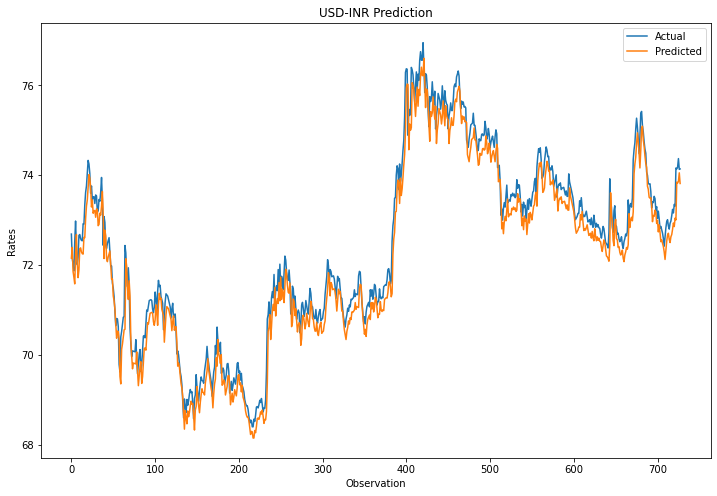

In [108]:
NeuralNet_Plot(y_test2,y_pred2)

##  Gated Recurrent Unit(GRU)

* It also have the characterstics to retain the long term dependency of past sequence of events.
* GRUs expose the entire cell state to other units in the network.
* GRU performs both forget and update gate operations together via its reset gate.

In [109]:
def GRU_Model(df1):
    
    df1 = np.array(df1).reshape(-1,1)
    scaler = MinMaxScaler()
    df_1 = scaler.fit_transform(df1)
    
    #Training and test sets
    train = df_1[:11919]
    test = df_1[11919:]
      
    def get_df1(df1, look_back):
        df1_x, df1_y = [],[]
        for i in range(len(df1)-look_back-1):
            df1_x.append(df1[i:(i+look_back),0])
            df1_y.append(df1[i+look_back,0])
        return np.array(df1_x) , np.array(df1_y)

    look_back = 1

    X_train , y_train = get_df1(train, look_back)
    X_test , y_test = get_df1(test,look_back)
    
    #Processing train and test sets for LSTM model
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
    
    K.clear_session()
    gru_model = Sequential()
    gru_model.add(GRU(12, input_shape=(1, X_train.shape[1]), activation='linear', kernel_initializer='lecun_uniform', return_sequences=False))
    gru_model.add(Dense(1))
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)
    gru_model.compile(loss='mse', optimizer= 'adam', metrics=[tensorflow.keras.metrics.RootMeanSquaredError(name='rmse')])
    gru_model.fit(X_train, y_train, epochs=100, batch_size=20, verbose=1, shuffle=False,callbacks=[early_stop])
    gru_model.summary()
    
    #Prediction
    y_pred = gru_model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test = np.array(y_test).reshape(-1,1)
    y_test = scaler.inverse_transform(y_test)
    
#     test_mse = tensorflow.keras.metrics.mean_squared_error(y_test, y_pred)
#     rmse_test = np.sqrt(test_mse)
    print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred)))
    r2_test = r2_score(y_test, y_pred)
    print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)
    print("Root Mean Squared Error: %.3f" %rmse)
    
    return y_test,y_pred

In [110]:
y_test3,y_pred3 = GRU_Model(df1)

Epoch 1/100
596/596 [==============================] - 5s 2ms/step - loss: 1.2706e-04 - rmse: 0.0113
Epoch 2/100
596/596 [==============================] - 2s 3ms/step - loss: 0.0015 - rmse: 0.0386
Epoch 3/100
596/596 [==============================] - 1s 2ms/step - loss: 2.4769e-04 - rmse: 0.0157
Epoch 4/100
596/596 [==============================] - 1s 2ms/step - loss: 3.8717e-05 - rmse: 0.0062
Epoch 5/100
596/596 [==============================] - 1s 2ms/step - loss: 1.0879e-05 - rmse: 0.0033
Epoch 6/100
596/596 [==============================] - 1s 2ms/step - loss: 7.1308e-06 - rmse: 0.0027
Epoch 7/100
596/596 [==============================] - 1s 2ms/step - loss: 6.6658e-06 - rmse: 0.0026
Epoch 8/100
596/596 [==============================] - 2s 3ms/step - loss: 6.8861e-06 - rmse: 0.0026
Epoch 9/100
596/596 [==============================] - 2s 3ms/step - loss: 7.1589e-06 - rmse: 0.0027
Epoch 10/100
596/596 [==============================] - 1s 2ms/step - loss: 7.0533e-06 - rmse: 

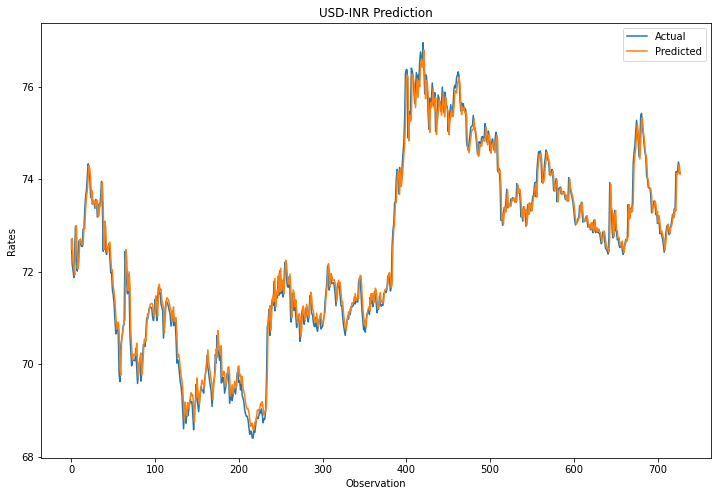

In [111]:
NeuralNet_Plot(y_test3,y_pred3)

# Finalized The Model

## Compare all models with error values for prediction as follows,

* Holt's Method   - RMSE(2.89)
* AR Model        - RMSE(4.2) 
* ARIMA Model     - RMSE(0.205)
* Fbprophet Model       - RMSE(4.1)
* Pycaret Model(xgboost)   - RMSE(5.83)
* ANN- RMSE(0.6)
* LSTM- RSME(0.4)
* GRU- RSME(0.28)

# Deployment using ARIMA Model

In [354]:
import streamlit as st

predicted=73.242710, expected=73.300003
predicted=73.316392, expected=73.040001
predicted=73.047061, expected=73.199997
predicted=73.215072, expected=73.029999
predicted=73.031022, expected=72.820000
predicted=72.837756, expected=72.860001
predicted=72.874912, expected=72.779999
predicted=72.785071, expected=72.709999
predicted=72.720691, expected=72.589996
predicted=72.601146, expected=72.419998
predicted=72.434498, expected=72.625000
predicted=72.634776, expected=72.830002
predicted=72.821612, expected=72.970001
predicted=72.962890, expected=73.010002
predicted=73.007949, expected=72.870003
predicted=72.876200, expected=72.800003
predicted=72.813598, expected=72.930000
predicted=72.936418, expected=72.980003
predicted=72.978228, expected=73.099998
predicted=73.100795, expected=73.239998
predicted=73.237037, expected=73.160004
predicted=73.160223, expected=73.349998
predicted=73.355789, expected=73.309998
predicted=73.307062, expected=74.160004
predicted=74.151280, expected=74.139999


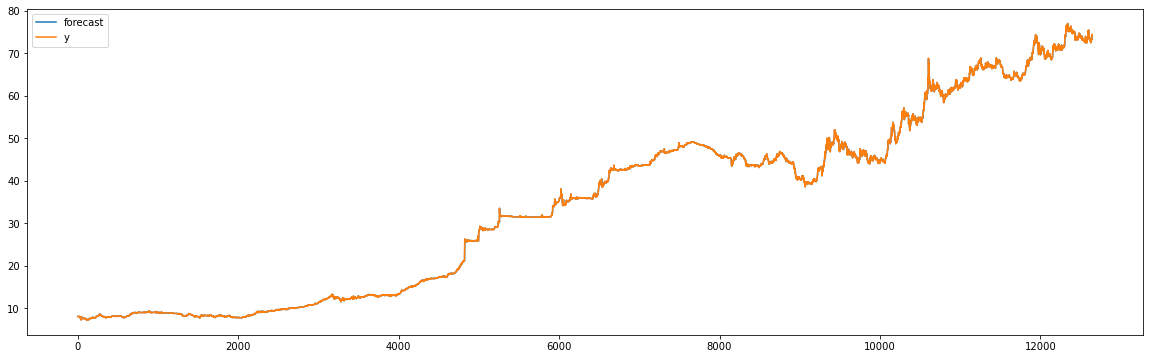

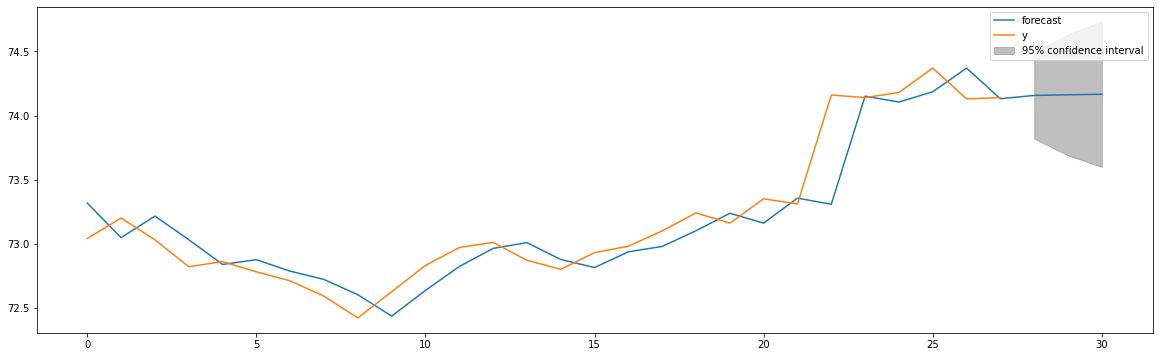

In [362]:
# pickling the model
import pickle
pickle_out = open("ARIMA_Model(df1,2,1,0).pkl", "wb")
pickle.dump(ARIMA_Model(df1,2,1,0), pickle_out)
pickle_out.close()

In [363]:
from PIL import Image

In [364]:
# loading in the model to predict on the data
pickle_in = open('ARIMA_Model(df1,2,1,0).pkl', 'rb')
Regressor = pickle.load(pickle_in)

def welcome():
    return 'welcome all'
  

In [369]:
def prediction(Dates,Rates):  
   
    prediction = Regressor.predict(
        [[Dates, Rates]])
    print(prediction)
    return prediction

In [371]:
# this is the main function in which we define our webpage 
def main():
      # giving the webpage a title
    st.title("Exchange Rate's For USD/INR Forecasting")
    
# here we define some of the front end elements of the web page like 
    # the font and background color, the padding and the text to be displayed
    html_temp = """
    <div style ="background-color:yellow;padding:13px">
    <h1 style ="color:black;text-align:center;">Streamlit Exchange Rate Forecasting ML App </h1>
    </div>
    """    
    
# this line allows us to display the front end aspects we have 
    # defined in the above code
    st.markdown(html_temp, unsafe_allow_html = True)  
    
    # the following lines create text boxes in which the user can enter 
    # the data required to make the prediction
    Date = st.text_input("Date", "Type Here")
    Rate = st.text_input("rate", "Type Here")
    result =""
    
    # the below line ensures that when the button called 'Predict' is clicked, 
    # the prediction function defined above is called to make the prediction 
    # and store it in the variable result
    if st.button("Predict"):
        result = prediction(Date, Rate)
    st.success('The output is {}'.format(result))
    
    
if __name__=='__main__':
    main()
     

In [368]:
def welcome():
    return 'welcome all'
  
# defining the function which will make the prediction using 
# the data which the user inputs
def prediction(): 
    for i in range(len(test)):
        arima_model = ARIMA(history, order=(p,d,q)).fit()
        output = arima_model.forecast()
        ypred = output[0]
   

In [355]:
st.title('Time Series Forecasting Using Streamlit')

  command:

    streamlit run C:\Users\tejuh\anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2021-08-18 17:58:39.892 WARNING root: 
  command:

    streamlit run C:\Users\tejuh\anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None)

In [356]:
st.write("SELECT FORECAST PERIOD") #text displayed

In [357]:
periods_input = st.number_input('How many days forecast do you want?',
 min_value = 1, max_value = 365)
#The minimum number of days a user can select is one, while the maximum is  #365 (yearly forecast) 